In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
root='/Genomics/pritykinlab/zzhao/metabolic_analysis'
filename = f'{root}/metabolic_analysis/data/th_data/GSE162300_DFMO_RNA_TPMs.tsv'
reaction_meta_file = f'{root}/Compass/compass/Resources/Recon2_export/rxn_md.csv'
reaction_output_file = f'{root}/metabolic_analysis/compass_results/reactions.tsv'

In [3]:
reaction_metadata = pd.read_csv(reaction_meta_file, index_col = 0)
reaction_penalties = pd.read_csv(reaction_output_file, sep='\t', index_col=0)
reaction_metadata

,rxn_name_long,subsystem,ind_in_original_recon,rxn_EC_number,genes_associated_with_rxn,rxn_formula,rxn_confidence
rxn_code_nodirection,,,,,,,
10FTHF5GLUtl,"5-glutamyl-10FTHF transport, lysosomal","Transport, lysosomal",1,NaN,NaN,1.00 * 10-formyltetrahydrofolate-[Glu](5) [c] ...,2.0
10FTHF5GLUtm,"5-glutamyl-10FTHF transport, mitochondrial","Transport, mitochondrial",2,NaN,NaN,1.00 * 10-formyltetrahydrofolate-[Glu](5) [m] ...,2.0
10FTHF6GLUtl,"6-glutamyl-10FTHF transport, lysosomal","Transport, lysosomal",3,NaN,NaN,1.00 * 10-formyltetrahydrofolate-[Glu](6) [c] ...,2.0
10FTHF6GLUtm,"6-glutamyl-10FTHF transport, mitochondrial","Transport, mitochondrial",4,NaN,NaN,1.00 * 10-formyltetrahydrofolate-[Glu](6) [m] ...,2.0
10FTHF7GLUtl,"7-glutamyl-10FTHF transport, lysosomal","Transport, lysosomal",5,NaN,NaN,1.00 * 10-formyltetrahydrofolate-[Glu](7) [c] ...,2.0
...,...,...,...,...,...,...,...
MAL_Lte,Transport of L-malate,"Transport, extracellular",7436,NaN,NaN,1.00 * (S)-malate(2-) [e] --> 1.00 * (S)-malat...,NaN
OROTGLUt,OROTGLUt,"Transport, extracellular",7437,NaN,SLC22A7,1.00 * L-glutamate(1-) [c] + 1.00 * Orotate [e...,NaN
PNTOte,Transport of (R)-Pantothenate,"Transport, extracellular",7438,NaN,NaN,1.00 * (R)-Pantothenate [e] --> 1.00 * (R)-Pan...,NaN


In [4]:
#This function is repeated here for clarity
def get_reaction_consistencies(compass_reaction_penalties, min_range=1e-3):
    """
        Converts the raw penalties outputs of compass into scores per reactions where higher numbers indicate more activity
    """
    df = -np.log(compass_reaction_penalties + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    return df

In [5]:
reaction_consistencies = get_reaction_consistencies(reaction_penalties)

In [7]:
from compass_analysis import cohens_d, wilcoxon_test, get_reaction_consistencies, get_metareactions, labeled_reactions, amino_acid_metab


In [10]:
Th17p_Vehicle = reaction_consistencies.filter(like='Th17p_Vehicle').columns
print(Th17p_Vehicle)
Th17n_Vehicle = reaction_consistencies.filter(like='Th17n_Vehicle').columns
print(Th17n_Vehicle)

Index(['Th17p_Vehicle_WT1_run1', 'Th17p_Vehicle_WT1_run2',
       'Th17p_Vehicle_WT2_run1', 'Th17p_Vehicle_WT2_run2',
       'Th17p_Vehicle_WT3_run1', 'Th17p_Vehicle_WT3_run2'],
      dtype='object')
Index(['Th17n_Vehicle_WT1_run1', 'Th17n_Vehicle_WT1_run2',
       'Th17n_Vehicle_WT2_run1', 'Th17n_Vehicle_WT2_run2',
       'Th17n_Vehicle_WT3_run1', 'Th17n_Vehicle_WT3_run2'],
      dtype='object')


In [11]:
wilcox_results = wilcoxon_test(reaction_consistencies, Th17p_Vehicle, Th17n_Vehicle)
# wilcox_results = wilcoxon_test(reaction_consistencies, Th17p, Th17n)
wilcox_results['metadata_r_id'] = ""
for r in wilcox_results.index:
    if r in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")

In [12]:
wilcox_results

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id
10FTHF5GLUtl_pos,33.0,0.015152,2.159993,0.035875,10FTHF5GLUtl
10FTHF5GLUtm_pos,34.0,0.008658,1.787591,0.027357,10FTHF5GLUtm
10FTHF6GLUtl_pos,33.0,0.015152,1.988012,0.035875,10FTHF6GLUtl
10FTHF6GLUtm_pos,34.0,0.008658,1.821178,0.027357,10FTHF6GLUtm
10FTHF7GLUtl_pos,33.0,0.015152,1.723774,0.035875,10FTHF7GLUtl
...,...,...,...,...,...
sink_decdicoa(c)_neg,28.0,0.132035,1.275588,0.178821,sink_decdicoa(c)
sink_octdececoa(c)_neg,34.0,0.008658,2.464836,0.027357,sink_octdececoa(c)
sink_pre_prot(r)_neg,28.0,0.132035,1.279011,0.178821,sink_pre_prot(r)
sink_tetdec2coa(c)_neg,28.0,0.132035,1.275588,0.178821,sink_tetdec2coa(c)


In [13]:
W = wilcox_results.merge(reaction_metadata, how='left',
                         left_on='metadata_r_id', right_index=True, validate='m:1')
# W = W[W['rxn_confidence'].isin([0,4])]
W = W[W['rxn_confidence'].isin([1,2,3,4])]
W = W[~W['rxn_EC_number'].isna()]
# new
W = W[~W['genes_associated_with_rxn'].isna()]
W.loc[(W['rxn_formula'].map(lambda x: '[m]' not in x)) & (W['subsystem'] == "Citric acid cycle"), 'subsystem'] = 'Other'

In [15]:
W[W['adjusted_pval']<0.05].sort_values(by=['adjusted_pval'])

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id,rxn_name_long,subsystem,ind_in_original_recon,rxn_EC_number,genes_associated_with_rxn,rxn_formula,rxn_confidence
34DHOXPEGOX_pos,36.0,0.002165,3.258966,0.014495,34DHOXPEGOX,"3,4-Dihydroxyphenylethyleneglycol:NAD+ oxidore...",Tyrosine metabolism,47,1.1.1.1,ADH1; ADH4; ADH5; ADH6A; ADH7; ADHFE1,1.00 * proton [c] + 1.00 * Nicotinamide adenin...,4.0
NACHEX6ly_pos,36.0,0.002165,2.355669,0.014495,NACHEX6ly,"beta-N-acetylhexosaminidase, lysosomal",Chondroitin sulfate degradation,2639,3.2.1.52,HEXA; HEXB,1.00 * Water [l] + 1.00 * chondroitin sulfate ...,4.0
MTHFR3_pos,36.0,0.002165,2.669348,0.014495,MTHFR3,"5,10-methylenetetrahydrofolatereductase (NADPH)",Folate metabolism,7373,1.5.1.20,MTHFR,2.00 * proton [c] + 1.00 * Nicotinamide adenin...,2.0
MTHFD_pos,36.0,0.002165,2.324762,0.014495,MTHFD,methylenetetrahydrofolate dehydrogenase (NADP),Folate metabolism,2602,1.5.1.5,MTHFD1; MTHFR,1.00 * Nicotinamide adenine dinucleotide phosp...,4.0
MTHFD2_neg,36.0,0.002165,2.324762,0.014495,MTHFD2,methylenetetrahydrofolate dehydrogenase (NAD),Folate metabolism,2603,1.5.1.5,MTHFD2; MTHFD2L,1.00 * Nicotinamide adenine dinucleotide [c] +...,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
NACHEX17ly_pos,33.0,0.015152,1.787042,0.035875,NACHEX17ly,"beta-N-acetylhexosaminidase, lysosomal",Keratan sulfate degradation,2623,3.2.1.52,HEXA; HEXB,"1.00 * Water [l] + 1.00 * keratan sulfate I, d...",4.0
NACHEX18ly_pos,33.0,0.015152,1.787042,0.035875,NACHEX18ly,"beta-N-acetylhexosaminidase, lysosomal",Keratan sulfate degradation,2624,3.2.1.52,HEXA; HEXB,"1.00 * Water [l] + 1.00 * keratan sulfate I, d...",4.0
NACHEX19ly_pos,33.0,0.015152,1.787042,0.035875,NACHEX19ly,"beta-N-acetylhexosaminidase, lysosomal",Keratan sulfate degradation,2625,3.2.1.52,HEXA; HEXB,"1.00 * Water [l] + 1.00 * keratan sulfate I, d...",4.0
IDOAASE2ly_pos,33.0,0.015152,1.700382,0.035875,IDOAASE2ly,"alpha-L-iduronidase, lysosomal",Heparan sulfate degradation,2319,3.2.1.76,IDUA,"1.00 * Water [l] + 1.00 * heparan sulfate, deg...",4.0


In [16]:
W[W['adjusted_pval']<0.05]['subsystem'].value_counts()

Nucleotide interconversion     128
Fatty acid oxidation            51
Keratan sulfate degradation     42
Sphingolipid metabolism         41
Keratan sulfate synthesis       33
                              ... 
Biotin metabolism                1
Transport, lysosomal             1
Cytochrome metabolism            1
Propanoate metabolism            1
Citric acid cycle                1
Name: subsystem, Length: 63, dtype: int64

In [17]:
gene_set_all = []
for gene_list in W[W['adjusted_pval']<0.05]['genes_associated_with_rxn'].values:
    if type(gene_list) is not float:
        gene_set_all.extend(gene_list.split('; '))
print(len(gene_set_all))

1312


In [18]:
from collections import Counter
Counter(gene_set_all).most_common()

[('CMPK1', 74),
 ('HEXA', 22),
 ('HEXB', 22),
 ('CTSA', 22),
 ('GALNS', 22),
 ('GLB1', 22),
 ('NEU1', 22),
 ('GM20390', 21),
 ('NME2', 21),
 ('FPGS', 18),
 ('B4GALT1', 16),
 ('B4GALT2', 16),
 ('B4GALT3', 16),
 ('B4GALT5', 16),
 ('B3GNT2', 15),
 ('B3GNT3', 15),
 ('B3GNT4', 15),
 ('B3GNT7', 15),
 ('B3GNT8', 15),
 ('B3GNTL1', 15),
 ('B4GAT1', 15),
 ('CPT1A', 14),
 ('GNS', 14),
 ('CPT1B', 13),
 ('CPT1C', 13),
 ('ACADM', 12),
 ('ACADS', 12),
 ('PNP2', 12),
 ('FUT9', 11),
 ('EHHADH', 9),
 ('NT5C', 9),
 ('NT5C3', 9),
 ('NT5E', 9),
 ('ACOX1', 8),
 ('ACSL1', 8),
 ('ST6GALNAC2', 8),
 ('ACAA1B', 7),
 ('HSD17B4', 7),
 ('FUT1', 7),
 ('GUSB', 7),
 ('NT5C1A', 7),
 ('NT5C1B', 7),
 ('SULT1A1', 6),
 ('HADHB', 6),
 ('NT5C2', 6),
 ('ST8SIA5', 6),
 ('UGT1A8', 6),
 ('ELOVL2', 5),
 ('ELOVL5', 5),
 ('ELOVL6', 5),
 ('MTHFD1', 5),
 ('NAGLU', 5),
 ('BCAT2', 5),
 ('CYP27A1', 5),
 ('ADH1', 4),
 ('ADH4', 4),
 ('ADH5', 4),
 ('ADH6A', 4),
 ('ADH7', 4),
 ('ADHFE1', 4),
 ('ADA', 4),
 ('ENTPD1', 4),
 ('ENTPD3', 4),
 ('E

In [28]:
W['subsystem'].value_counts()

Nucleotide interconversion     174
Fatty acid oxidation           145
Keratan sulfate degradation     59
Sphingolipid metabolism         44
Tyrosine metabolism             41
                              ... 
Ubiquinone synthesis             1
Vitamin C metabolism             1
CoA synthesis                    1
O-glycan synthesis               1
Thiamine metabolism              1
Name: subsystem, Length: 75, dtype: int64

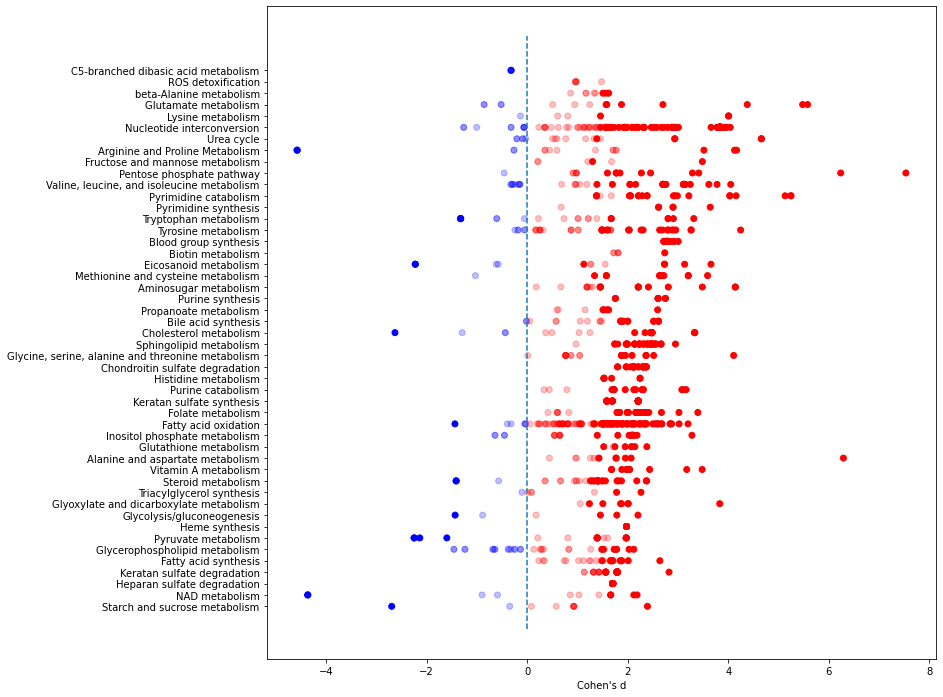

In [37]:
data = W[~W['subsystem'].isin(["Miscellaneous", "Unassigned"])]
data = data[~data['subsystem'].map(lambda x: "Transport" in x or "Exchange" in x or x == "Other")]
items, counts = np.unique(data['subsystem'], return_counts=True)
items = [items[i] for i in range(len(items)) if counts[i] > 5] #filter(n() > 5) %>%
data = data[data['subsystem'].isin(items)]
plt.figure(figsize=(12,12))
axs = plt.gca()
#Sorts the reactions for plotting
d = data[data['adjusted_pval'] < 0.05].groupby('subsystem')['cohens_d'].median().abs()
axs.scatter(d[d.argsort], d[d.argsort].index, alpha=0)
color = data['cohens_d'].map(lambda x: 'r' if x >= 0 else 'b')
alpha = data['adjusted_pval'].map(lambda x: 1.0 if x < 0.1 else 0.25)
axs.scatter(data['cohens_d'], data['subsystem'], c=color, alpha=alpha)
axs.set_xlabel("Cohen's d")
axs.vlines(x=0, ymin=-2, ymax=50, linestyles='--')

In [49]:
print(data[data['adjusted_pval'] < 0.05].groupby('subsystem')['cohens_d'].quantile([.25]))

subsystem                                              
Alanine and aspartate metabolism                   0.25    2.008974
Aminosugar metabolism                              0.25    2.208438
Arginine and Proline Metabolism                    0.25   -4.576983
Bile acid synthesis                                0.25    1.992928
Biotin metabolism                                  0.25    2.734501
Blood group synthesis                              0.25    2.759555
Cholesterol metabolism                             0.25    2.455463
Chondroitin sulfate degradation                    0.25    2.125289
Eicosanoid metabolism                              0.25   -0.987563
Fatty acid oxidation                               0.25    1.899411
Fatty acid synthesis                               0.25    1.692693
Folate metabolism                                  0.25    1.832860
Fructose and mannose metabolism                    0.25    3.482494
Glutamate metabolism                               0.25    3

In [24]:
import matplotlib.pyplot as plt
import matplotlib
def plot_differential_scores(data, title, c):
    plt.figure(figsize=(10,10))
    axs = plt.gca()
    axs.scatter(data['cohens_d'], -np.log10(data['adjusted_pval']), c=c)
    axs.set_xlabel("Cohen's d", fontsize=16)
    axs.set_ylabel("-log10 (Wilcoxon-adjusted p)", fontsize=16)
    #Everything after this should be tweaked depending on your application
    axs.set_xlim(-6.2, 6.2)
    axs.axvline(0, dashes=(3,3), c='black')
    axs.axhline(1, dashes=(3,3), c='black')
    axs.set_title(title, fontdict={'fontsize':20})
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(0, -0.08),
            arrowprops=dict(arrowstyle="<-", color='#348C73', linewidth=4))
    axs.annotate('Th17p_V', xy=(0.75, -0.12), xycoords='axes fraction', fontsize=16)
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(1, -0.08),
            arrowprops=dict(arrowstyle="<-", color='#E92E87', linewidth=4))
    axs.annotate('Th17n_V', xy=(0.25, -0.12), xycoords='axes fraction', fontsize=16)
    for r in data.index:
        if r in labeled_reactions:
            x = data.loc[r, 'cohens_d']
            y = -np.log10(data.loc[r, 'adjusted_pval'])
            offset = (20, 0)
            if x < 0:
                offset = (-100, -40)
            axs.annotate(labeled_reactions[r], (x,y), xytext = offset,
                         textcoords='offset pixels', arrowprops={'arrowstyle':"-"})

In [72]:
filtered_data = pd.concat([W[W['subsystem'] == "Nucleotide interconversion"],
                           W[W['subsystem'] == "Fatty acid oxidation"],
                           W[W['subsystem'] == "Keratan sulfate synthesis"],
                           W[W['subsystem'] == "Keratan sulfate degradation"],
                          ])

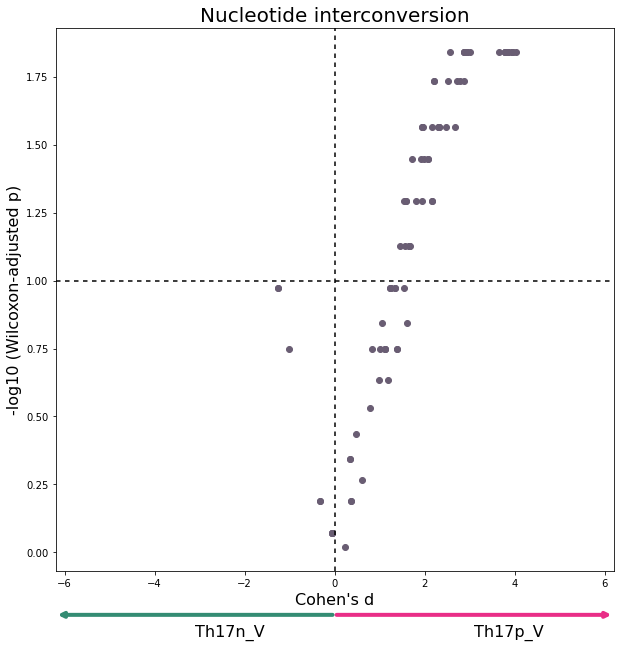

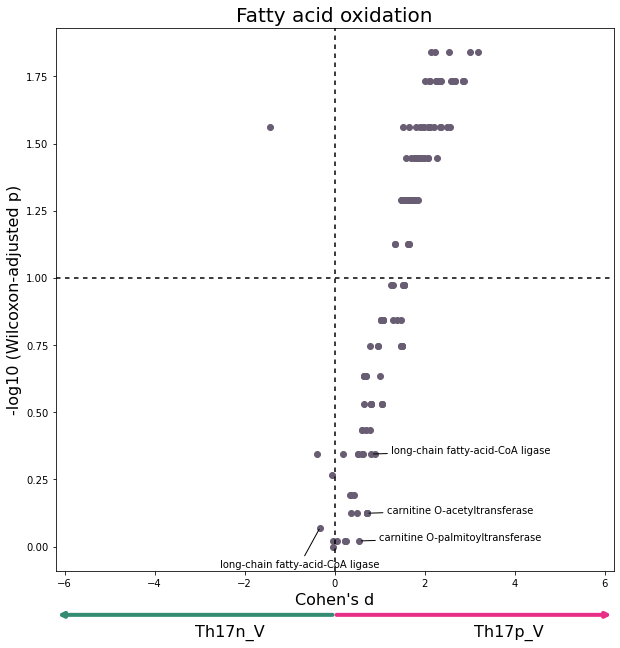

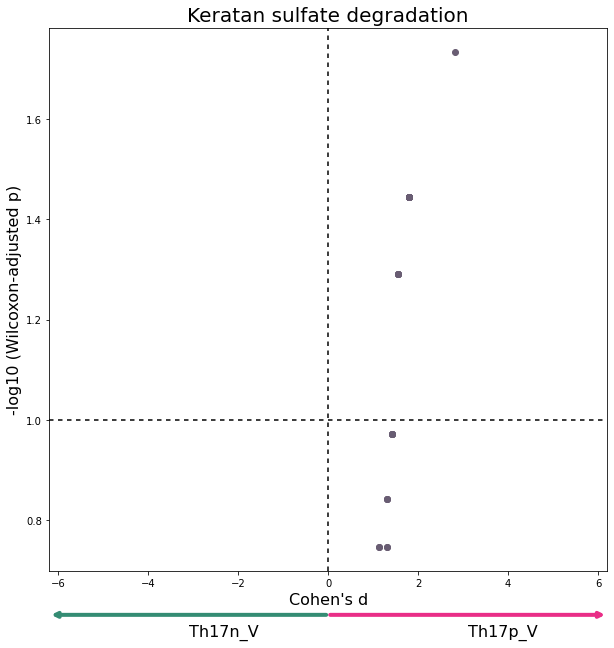

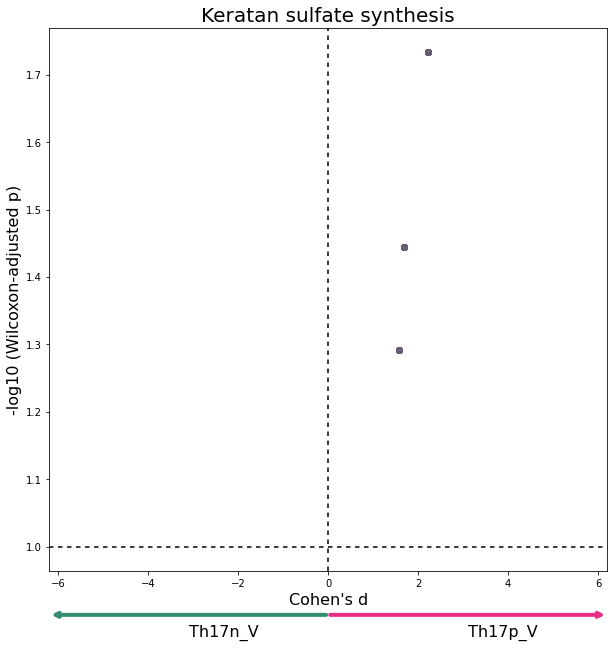

In [73]:
for item in filtered_data['subsystem'].value_counts().keys():
    data = W[W['subsystem'] == item]
    plot_differential_scores(data, title=item, c="#695D73")

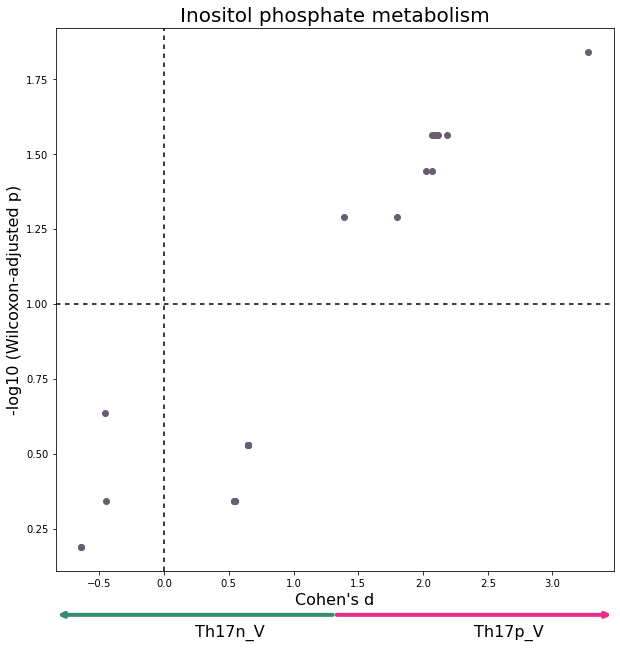

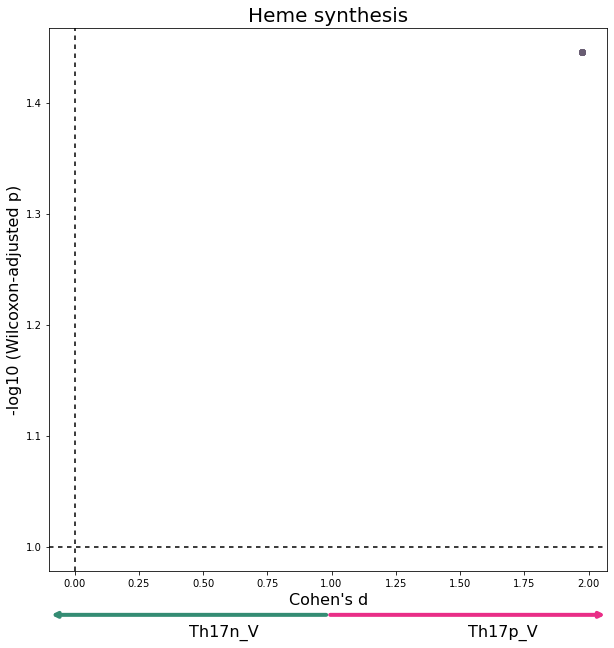

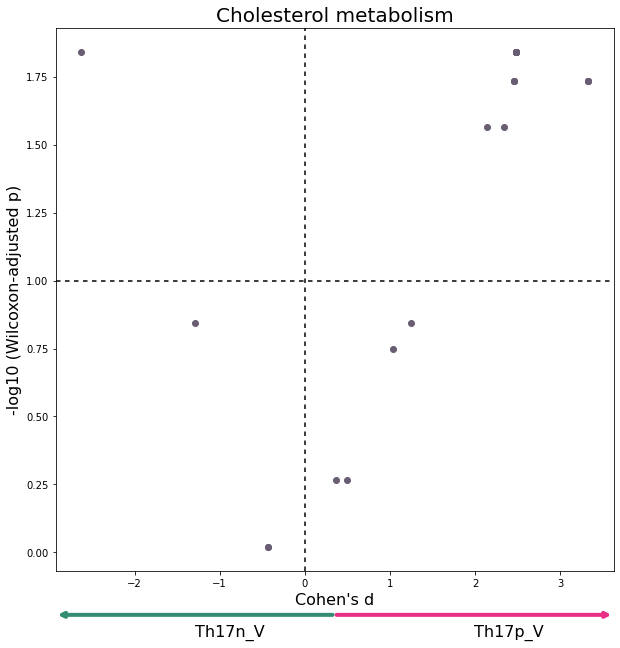

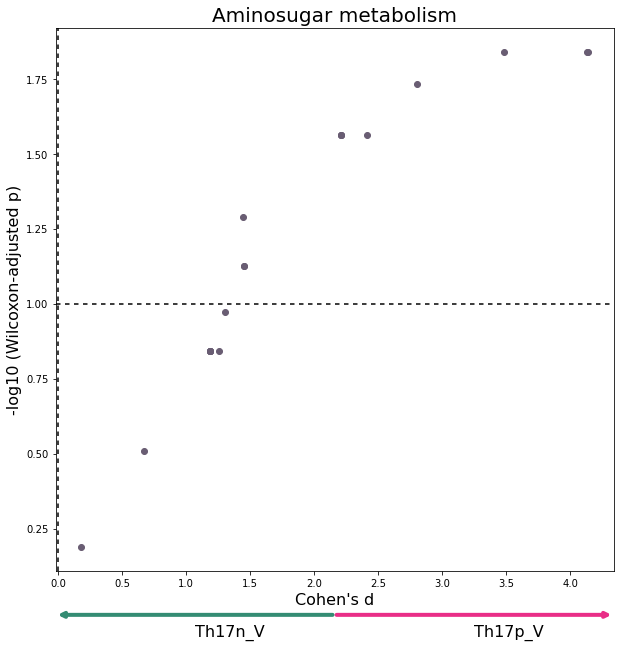

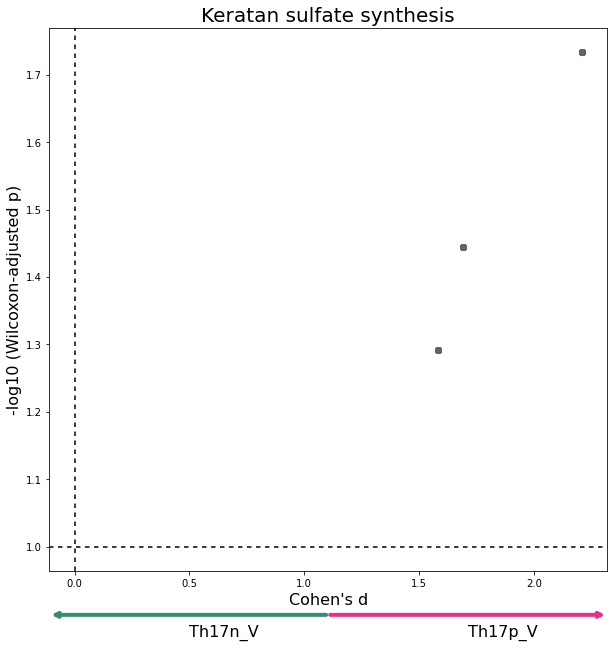

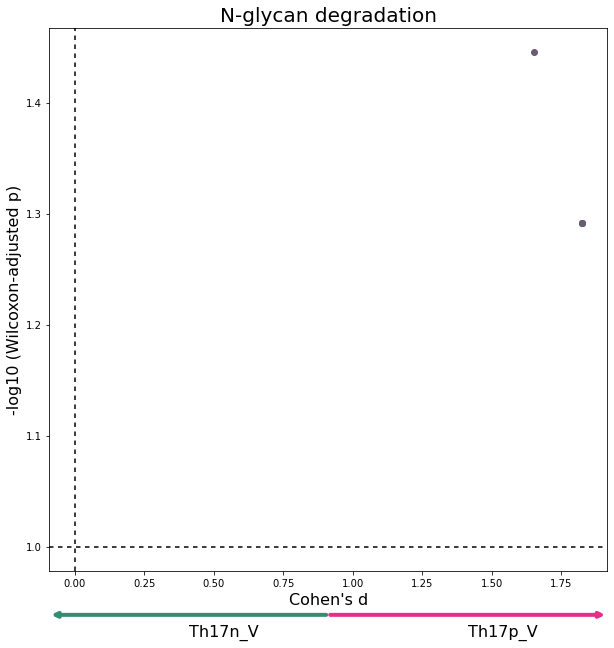

In [40]:
keys = ["Inositol phosphate metabolism", "Heme synthesis", "Cholesterol metabolism", 
        "Aminosugar metabolism", "Keratan sulfate synthesis", "N-glycan degradation"]
for item in keys:
    data = W[W['subsystem'] == item]
    plot_differential_scores(data, title=item, c="#695D73")